In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [5]:
df=pd.read_csv('heart.csv')
X=df.drop(['target'],axis=1)
y=df['target']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=1)

In [6]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다."
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기 개수와 가중치 개수는 동일해야 합니다.'
                             '; %d개의 가중치와, %d개의 분류기가 입력되었습니다.'
                             % (len(self.weights), len(self.classifiers)))
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

clf1 = LogisticRegression(solver='liblinear',
                          penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.93 (+/- 0.07) [Logistic regression]
ROC AUC: 0.75 (+/- 0.09) [Decision tree]
ROC AUC: 0.88 (+/- 0.06) [KNN]


In [8]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.93 (+/- 0.07) [Logistic regression]
ROC AUC: 0.75 (+/- 0.09) [Decision tree]
ROC AUC: 0.88 (+/- 0.06) [KNN]
ROC AUC: 0.94 (+/- 0.05) [Majority voting]


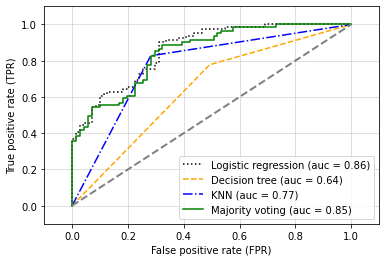

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc',
                    )
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.936 +/- 0.03 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.938 +/- 0.03 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.938 +/- 0.02 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.938 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.938 +/- 0.03 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.945 +/- 0.02 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [12]:
X=df.drop(['target'],axis=1)
y=df['target']
X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [13]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, # 500개의 결정 트리
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [15]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.754
배깅의 훈련 정확도/테스트 정확도 1.000/0.770


In [16]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [17]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

결정 트리의 훈련 정확도/테스트 정확도 0.777/0.689
에이다부스트의 훈련 정확도/테스트 정확도 0.930/0.803
